<a href="https://colab.research.google.com/github/daspartho/learn-pytorch/blob/main/paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torchvision
import torch

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modular import data_setup, engine
except:
    print("[INFO] Couldn't find modular scripts... downloading from GitHub.")
    !git clone https://github.com/daspartho/learn-pytorch
    !mv learn-pytorch/modular .
    !rm -rf learn-pytorch
    from modular import data_setup, engine

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modular scripts... downloading from GitHub.
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 133 (delta 57), reused 117 (delta 54), pack-reused 10
Receiving objects: 100% (133/133), 8.36 MiB | 24.52 MiB/s, done.
Resolving deltas: 100% (57/57), done.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3107 (delta 14), reused 34 (delta 12), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/ "train"
test_dir = image_path/ "test"

In [5]:
IMG_SIZE = 224

transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transforms,
    BATCH_SIZE,
)

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

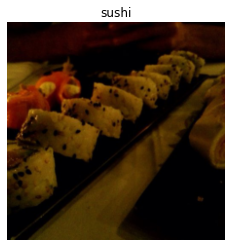

In [8]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [9]:
class PatchEmbedding(nn.Module):

    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        self.flatten = nn.Flatten(
            start_dim=2, 
            end_dim=3,
            )

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [10]:
print(f"Image shape: {image.shape}")

x = image.unsqueeze(dim=0)
print(f"Image with batch dim shape: {x.shape}")

patchify = PatchEmbedding()
patch_embedding = patchify(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

class_token = nn.Parameter(
    torch.randn(1, 1, 768), 
    requires_grad=True,
    )
print(f"Class token shape: {class_token.shape}")

patch_embedding_class_token = torch.cat(
    (class_token, patch_embedding), 
    dim=1,
    )
print(f"Patch embedding class token shape: {patch_embedding_class_token.shape}")

position_embedding = nn.Parameter(
    torch.randn(1, 197, 768),
    requires_grad=True,
)
print(f"Position embedding shape: {position_embedding.shape}")

patch_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch position embedding shape: {patch_position_embedding.shape}")

Image shape: torch.Size([3, 224, 224])
Image with batch dim shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch position embedding shape: torch.Size([1, 197, 768])


In [11]:
class MSABlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim = embedding_dim,
            num_heads = num_heads,
            dropout=attn_dropout,
            batch_first=True
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False
        )
        return attn_output

In [13]:
msa_block = MSABlock()

print(f"Input shape to MSA block: {patch_position_embedding.shape}")
msa_block_output = msa_block(patch_position_embedding)
print(f"Output shape of MSA block: {msa_block_output.shape}")

Input shape to MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [15]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size,
                ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim,
                ),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [16]:
mlp_block = MLPBlock()

print(f"Input shape to MLP block: {msa_block_output.shape}")
mlp_block_output = mlp_block(msa_block_output)
print(f"Output shape of MLP block: {mlp_block_output.shape}")

Input shape to MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1):
        super().__init__()

        self.msa_block = MSABlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout,
            )
        
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout,
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [19]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (msa_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     